# **\[SOLAR_A\]** DCRNN

JiyunLim  
2023-08-19

# 2023.08.15

> **변경사항** : RGCN_Learner 수정 - 일부기능추가

> **포인트** : 배치학습을 적용하여 update가 빨리이루어지도록 코드수정

In [14]:
# modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch geometric temporal
import torch_geometric_temporal
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import DCRNN

# torch
import torch
import torch.nn.functional as F


# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        edge_weights = np.array(self._dataset["weights"]).T
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = temporal_signal_split(self.dataset, train_ratio = self.train_ratio)
        self.len_test = self.test_dataset.snapshot_count
        self.len_tr = self.train_dataset.snapshot_count
    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            print(f'\repoch={self.epochs}\t loss={np.mean(losses_batch)}\n', end='', flush=True)
        self.losses.append(np.mean(losses_batch))
        self._savefigs() 
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend() 
        self.figs.append(fig)
        plt.close()
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 

In [15]:
class DC_RNN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(DC_RNN, self).__init__()
        self.recurrent = DCRNN(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

## Load data

In [10]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [11]:
# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

## sample codes

`-` y를 학습

In [227]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 4 
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = 8
lrnr.model = DC_RNN(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(5):    
    lrnr.learn()

epoch=1  loss=0.66744120146126251896057             
epoch=2  loss=0.172642510817494522188416    
epoch=3  loss=0.130164081404028942090454        
epoch=4  loss=0.116128631066097786222687        
epoch=5  loss=0.110200397020509078546295        

In [228]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [229]:
np.mean((y - yhat)**2)

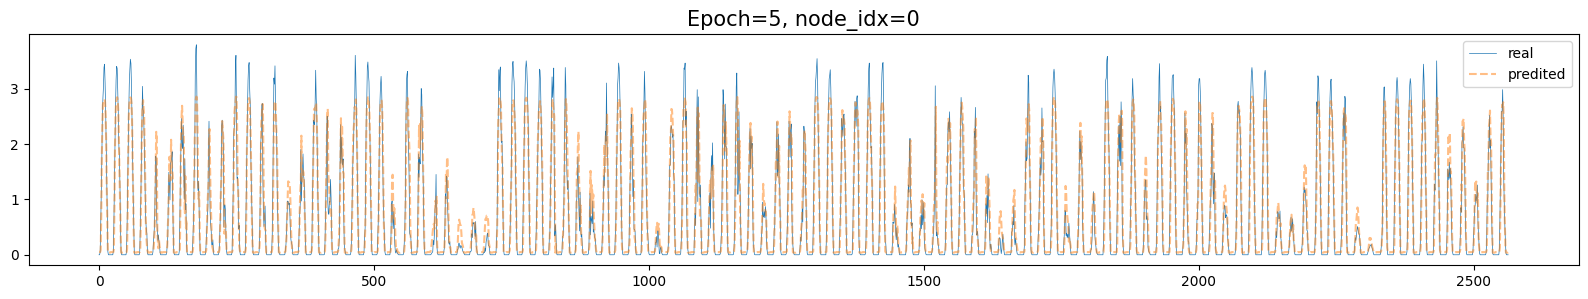

In [230]:
lrnr.figs[-1]

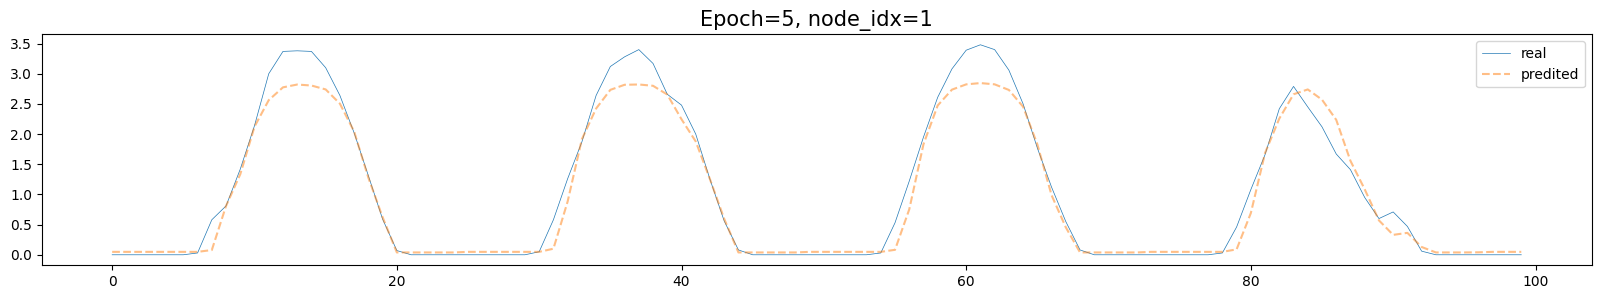

In [231]:
rslt_plot(y, yhat, 100, 1)

`-` yU 학습

In [232]:
# step1: create lrnr object
lrnr1 = RGCN_Learner()
# step2: load data 
lrnr1.lags = 4 
lrnr1.train_ratio = 0.8
lrnr1.load(yU) 
# step3: construct networks 
lrnr1.nof_filters = 8
lrnr1.model = DC_RNN(node_features=lrnr1.lags, filters=lrnr1.nof_filters).to(device)
lrnr1.optimizer = torch.optim.Adam(lrnr1.model.parameters(),lr=10/1000)
# step4: learn 
lrnr1.get_batches(batch_size=24)
for e in range(5):    
    lrnr1.learn()

epoch=1  loss=1.334470041096210536260986    
epoch=2  loss=0.501871485523013252146912    
epoch=3  loss=0.41614954034949462328186     
epoch=4  loss=0.262346962943326607994461        
epoch=5  loss=0.175828203992095120287018        

In [233]:
# yUhat_ = lrnr.yhat
yUhat = np.concatenate([np.array([list(lrnr1.yhat[0])]*lrnr1.lags),lrnr1.yhat],axis=0)

In [234]:
yU_mse = np.mean((yU - yUhat)**2)
yU_mse

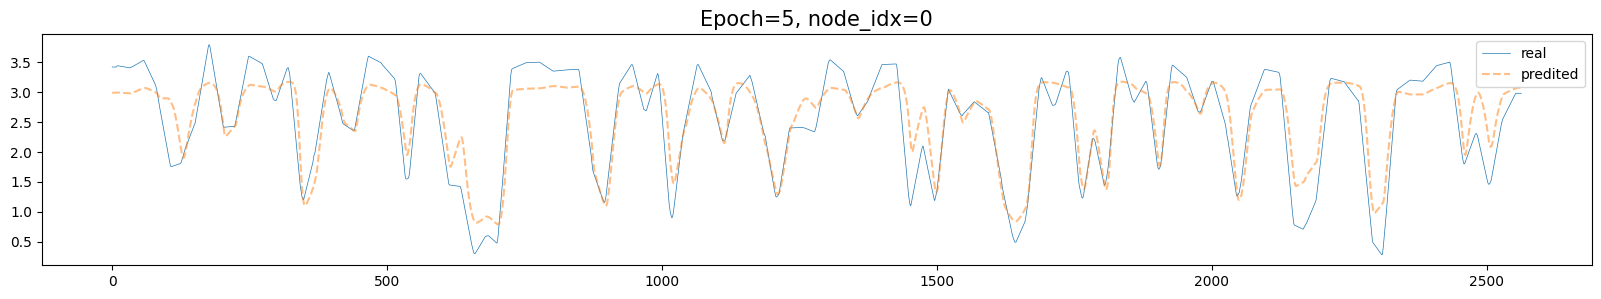

In [235]:
lrnr1.figs[-1]

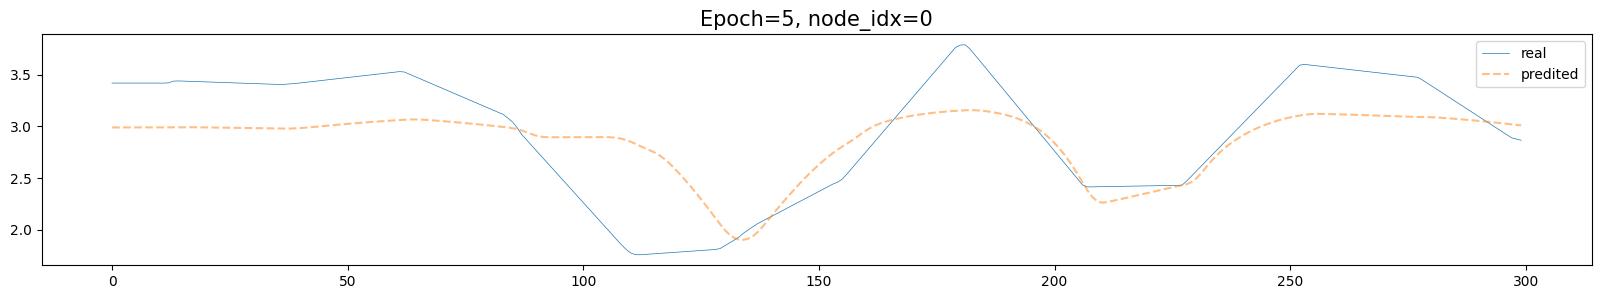

In [236]:
rslt_plot(yU, yUhat, 300, 0)

`-` yP 학습

In [ ]:
# step1: create lrnr object
lrnr2 = RGCN_Learner()
# step2: load data 
lrnr2.lags = 4 
lrnr2.train_ratio = 0.8
lrnr2.load(yP) 
# step3: construct networks 
lrnr2.nof_filters = 8
lrnr2.model = DC_RNN(node_features=lrnr2.lags, filters=lrnr2.nof_filters).to(device)
lrnr2.optimizer = torch.optim.Adam(lrnr2.model.parameters(),lr=10/1000)
# step4: learn 
lrnr2.get_batches(batch_size=24)
for e in range(5):    
    lrnr2.learn()

epoch=1  loss=0.0426005903458179448600464   
epoch=2  loss=0.012842223906434726622181            
epoch=3  loss=0.012220007448652111878071            
epoch=4  loss=0.011926000805160166350956            
epoch=5  loss=0.0117899504961272660204582       

In [238]:
lrnr2.losses[-1]

In [239]:
# yPhat_ = lrnr.yhat
yPhat = np.concatenate([np.array([list(lrnr2.yhat[0])]*lrnr2.lags),lrnr2.yhat],axis=0)
yPhat[yPhat<0] = 0

In [240]:
yP_mse = np.mean((yP - yPhat)**2)
yP_mse

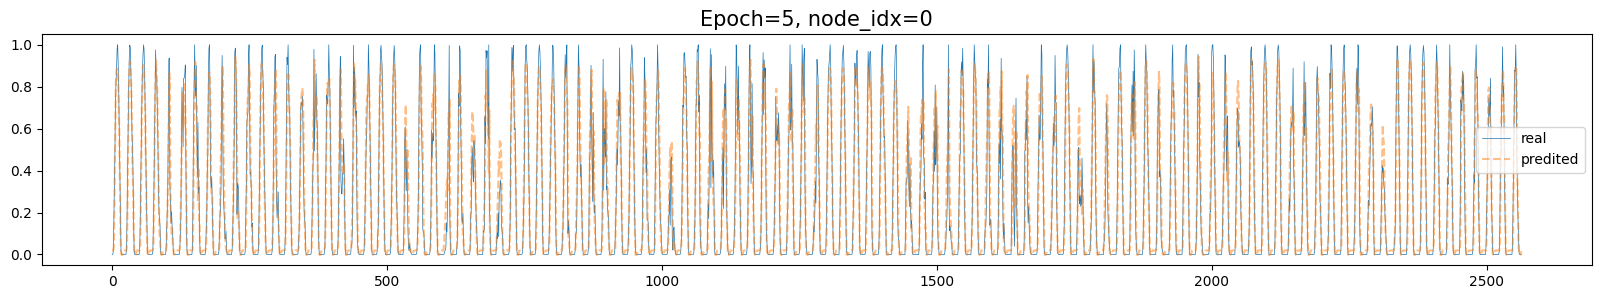

In [241]:
lrnr2.figs[-1]

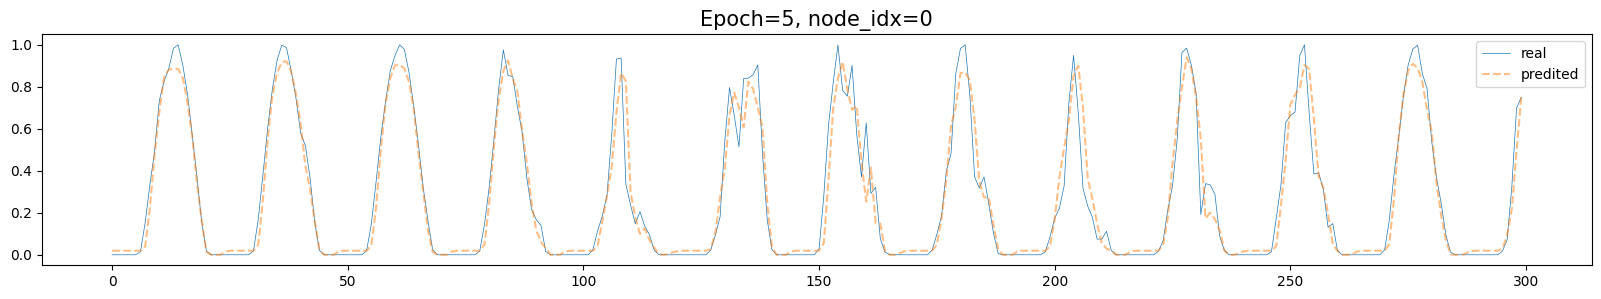

In [242]:
rslt_plot(yP, yPhat, 300, 0)

`-` classic vs. proposed

In [243]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
print('proposed(mse)', round(proposed,4))

classic(mse) 0.0718
proposed(mse) 0.0855

## 결과

In [244]:
# result_columns = ['lags', 'filters', 'epoch', 'classic(mse)', 'proposed(mse)']
# rslt_df = pd.DataFrame(columns=result_columns)

In [245]:
# new_rslt = pd.DataFrame({'lags':[lrnr.lags],'filters':[lrnr.nof_filters],'epoch':[lrnr.epochs],'classic(mse)': [round(classic, 4)], 'proposed(mse)': [round(proposed, 4)]})
new_rslt = pd.DataFrame({'lags':[lrnr.lags],'filters':[lrnr.nof_filters],'epoch':[lrnr.epochs],'classic(mse)': [round(classic, 4)], 'proposed(mse)': [round(proposed, 4)],'yU(mse)':[round(yU_mse,4)], 'yP(mse)':[round(yP_mse,4)]})
rslt_df = pd.concat([rslt_df, new_rslt], ignore_index=True)
rslt_df

-   lag4, filter=16(에폭15이상) 혹은 filter=32로 놓고 에폭 수를
    늘리면(에폭 20이상) 좋은듯하다.

------------------------------------------------------------------------

# 2023.08.24 (배치 사이즈변경)

In [32]:
def rslt_plot(lrnr, y, yhat, t_end=None, node_idx = None):
    with plt.style.context('default'):
        plt.ioff()
        plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
        node_idx = 0 if node_idx is None else node_idx
        t_end = lrnr.t if t_end is None else t_end
        fig,ax = plt.subplots()
        ax.plot(y[:t_end, node_idx], label='real', lw=0.5)
        ax.plot(yhat[:t_end, node_idx], '--', label='predicted', alpha=0.5)
        ax.set_title(f'Epoch = {lrnr.epochs}, node_idx = {node_idx}', size=15)
        ax.legend()

In [143]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 4 
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = 16
lrnr.model = DC_RNN(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(5):    
    lrnr.learn()

epoch=1  loss=0.385702304368795333340454        
epoch=2  loss=0.131466598878073135658875        
epoch=3  loss=0.112942590703104825003967        
epoch=4  loss=0.103844174248881124864502            
epoch=5  loss=0.10233745832256107116806             

In [144]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [145]:
np.mean((y - yhat)[LEN_TR]**2)

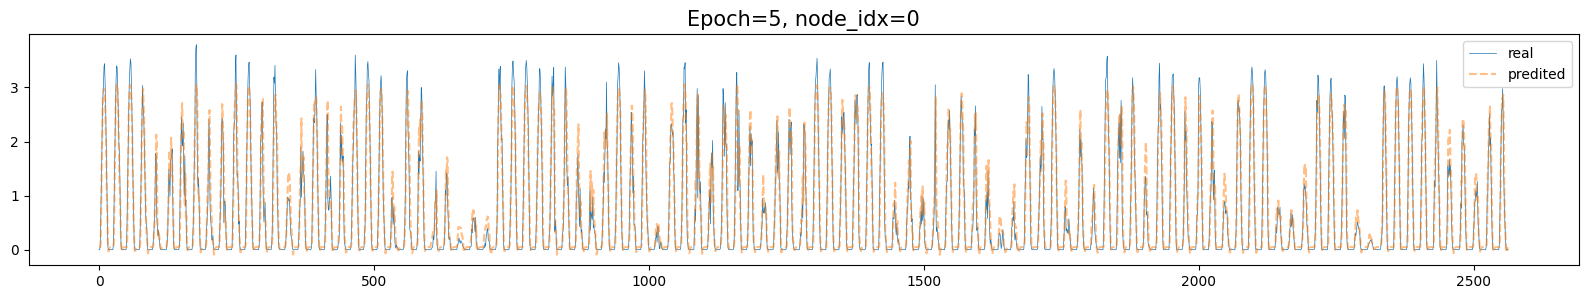

In [146]:
lrnr.figs[-1]

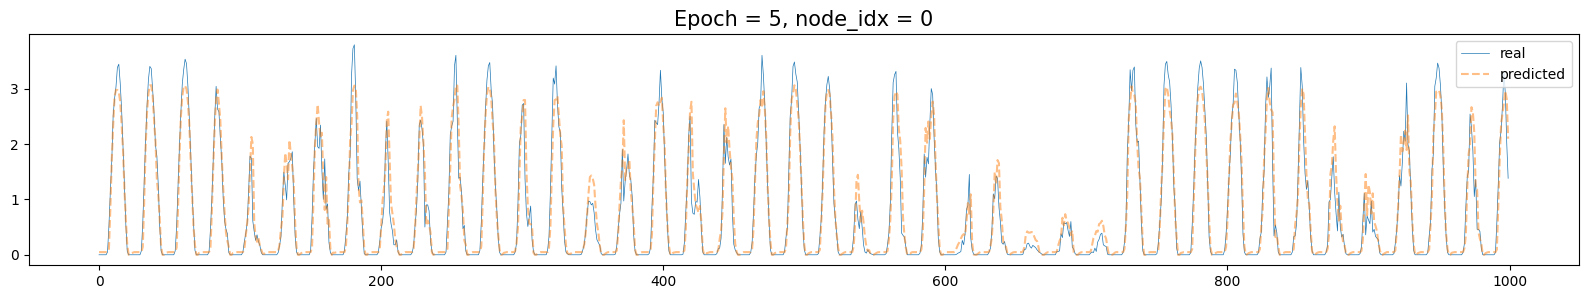

In [147]:
rslt_plot(lrnr, y, yhat, 1000, 0)

In [168]:
# step1: create lrnr object
lrnr1 = RGCN_Learner()
# step2: load data 
lrnr1.lags = 4 
lrnr1.train_ratio = 0.8
lrnr1.load(yU) 
# step3: construct networks 
lrnr1.nof_filters = 16
lrnr1.model = DC_RNN(node_features=lrnr1.lags, filters=lrnr1.nof_filters).to(device)
lrnr1.optimizer = torch.optim.Adam(lrnr1.model.parameters(),lr=5/1000)
# step4: learn 
lrnr1.get_batches(batch_size=24)
for e in range(5):    
    lrnr1.learn()

epoch=1  loss=1.69910632957552754099884     
epoch=2  loss=0.423218158008747352061005    
epoch=3  loss=0.1873466955541178151800156   
epoch=4  loss=0.123748297175002663070984        
epoch=5  loss=0.1048032042332166884601593   

In [169]:
yUhat = np.concatenate([np.array([list(lrnr1.yhat[0])]*lrnr1.lags),lrnr1.yhat],axis=0)

In [170]:
yU_mse = np.mean((yU - yUhat)**2)
yU_mse

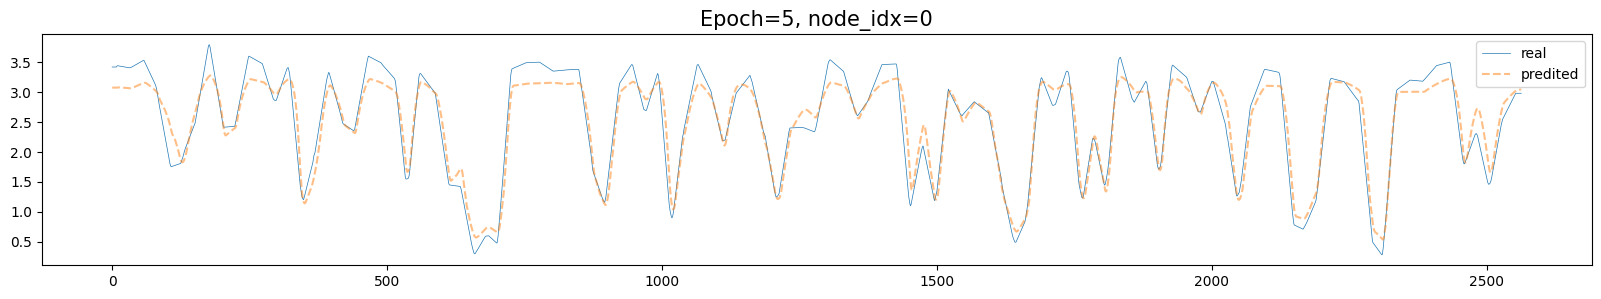

In [171]:
lrnr1.figs[-1]

In [149]:
# step1: create lrnr object
lrnr2 = RGCN_Learner()
# step2: load data 
lrnr2.lags = 4
lrnr2.train_ratio = 0.8
lrnr2.load(yP) 
# step3: construct networks 
lrnr2.nof_filters = 16
lrnr2.model = DC_RNN(node_features=lrnr2.lags, filters=lrnr2.nof_filters).to(device)
lrnr2.optimizer = torch.optim.Adam(lrnr2.model.parameters(),lr=10/1000)
# step4: learn 
lrnr2.get_batches(batch_size=24)
for e in range(5):    
    lrnr2.learn()

epoch=1  loss=0.0498911075640556472066498       
epoch=2  loss=0.0132738167966910927364807       
epoch=3  loss=0.0126674358034506449267044       
epoch=4  loss=0.0122204108602302378143196       
epoch=5  loss=0.0119707652118576825991516       

In [150]:
yPhat = np.concatenate([np.array([list(lrnr2.yhat[0])]*lrnr2.lags), lrnr2.yhat], axis=0)

In [151]:
yP_mse = np.mean((yP - yPhat)**2)
yP_mse

In [172]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
print('proposed(mse)', round(proposed,4))

classic(mse) 0.0643
proposed(mse) 0.0605

## Edit rgcn

In [173]:
# learn 
def rgcn(FX, model, train_ratio, lags, filters, epoch):
    # step1: create lrnr object
    lrnr = RGCN_Learner()
    # step2: load data
    lrnr.lags = lags
    lrnr.train_ratio = train_ratio
    lrnr.load(FX)
    # step3: construct networks
    lrnr.nof_filters = filters
    lrnr.model = model(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
    lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(), lr=10/1000)
    # step4: learn
    lrnr.get_batches(batch_size=128)
    for e in range(epoch):
        lrnr.learn()
    yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
    return yhat

In [174]:
# hyper params
LAGS = 4
FILTERS = 16
EPOCH = 5

`-` classic

In [175]:
yhat = rgcn(y, DC_RNN, train_ratio = TRAIN_RATIO, lags=LAGS, filters = FILTERS, epoch=EPOCH)
yhat[yhat<0] = 0

epoch=1  loss=0.8136012203553143366516  6       
epoch=2  loss=0.4804537226172054069336  6       
epoch=3  loss=0.2622013942283742483972      7       
epoch=4  loss=0.1447730577167342721515      8       
epoch=5  loss=0.13237281844896429820984 3           

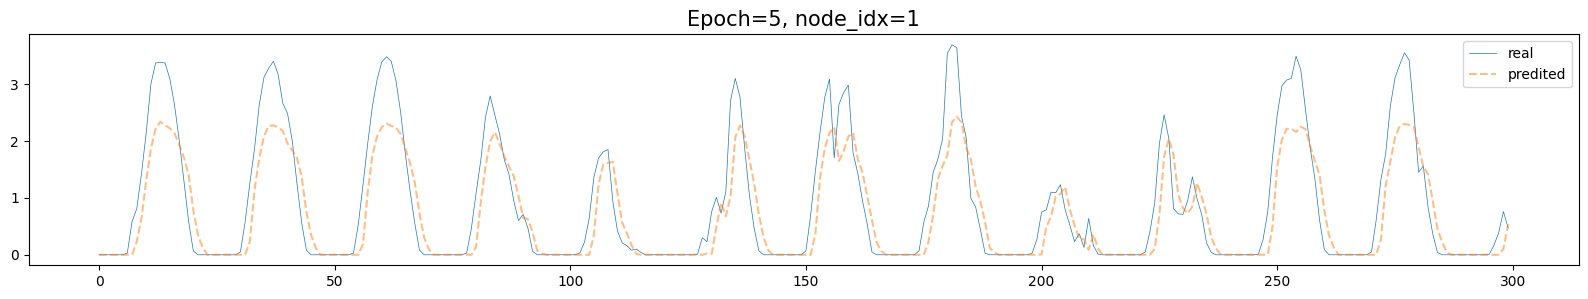

In [17]:
rslt_plot(y, yhat, 300, 1)

In [54]:
np.mean((y-yhat)[LEN_TR:,:]**2)

`-` proposed

In [55]:
# 방법2 
yUhat = rgcn(yU, GConv_LSTM, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP, GConv_LSTM, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 

classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

epoch=1  loss=1.213565460644489352722168    
epoch=2  loss=0.092817681646624281926613        
epoch=3  loss=0.027449196074591127543785            
epoch=4  loss=0.0185868418234032242759476       
epoch=5  loss=0.0118609502056050443508701       
epoch=1  loss=0.0224609425031515042299042       
epoch=2  loss=0.0119824765905261399890938       
epoch=3  loss=0.0112105506678046888116264       
epoch=4  loss=0.0109713261955157794609566       
epoch=5  loss=0.0108544562177104495387764       

total_mse(classic): 0.1451
total_mse(proposed): 0.1394


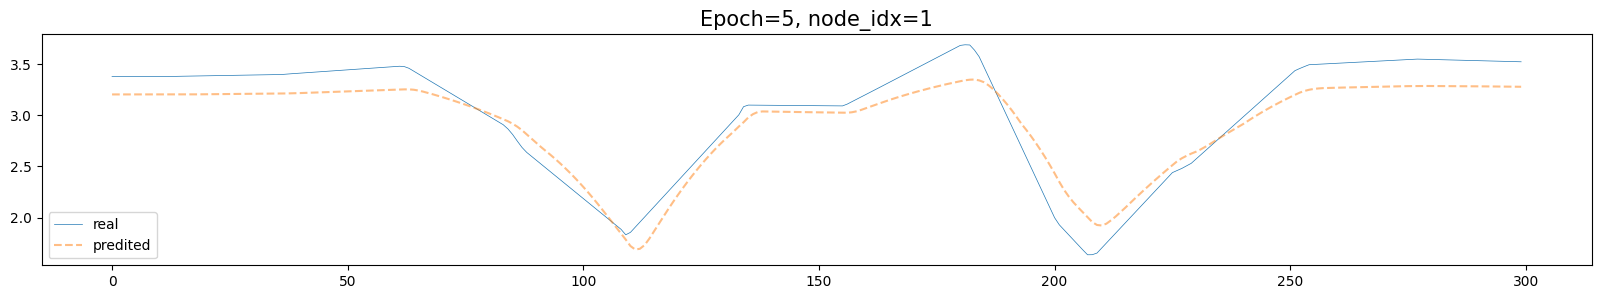

In [56]:
rslt_plot(yU, yUhat, 300, 1)

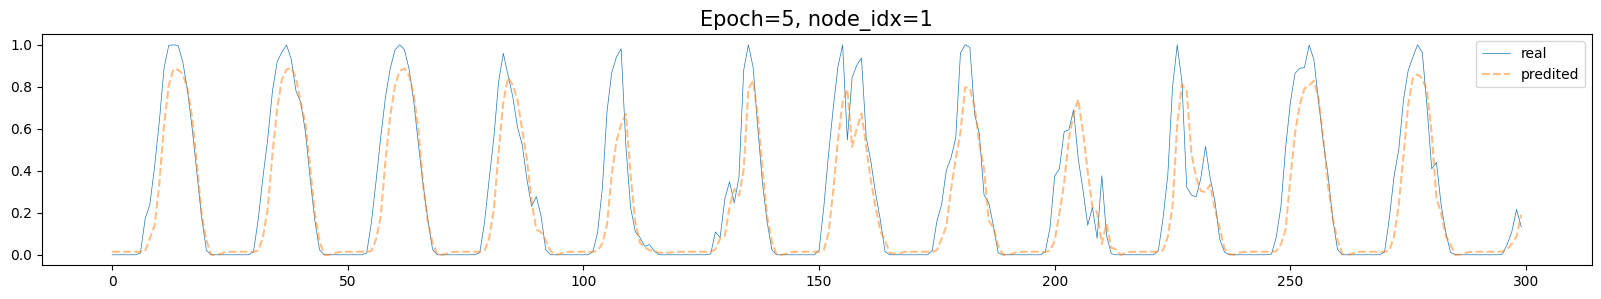

In [57]:
rslt_plot(yP, yPhat, 300, 1)

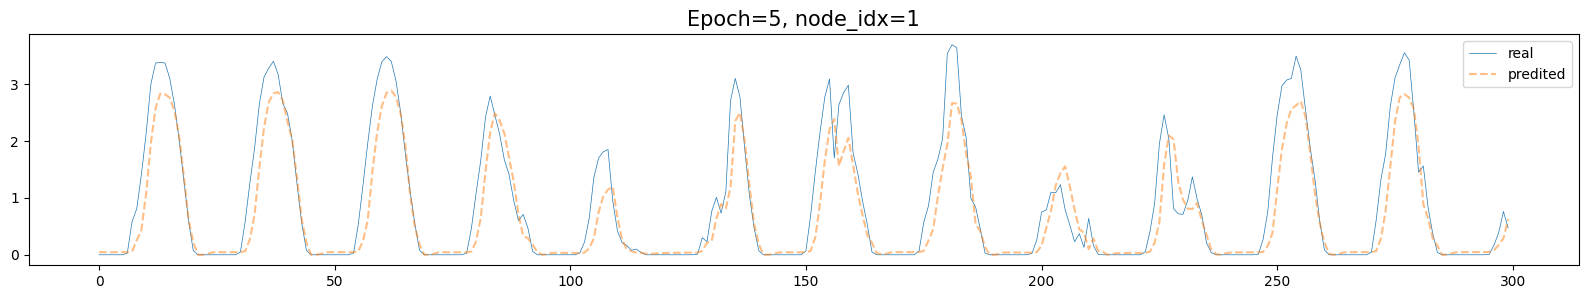

In [58]:
rslt_plot(y, yUhat*yPhat, 300, 1)

## simul code

In [60]:
# for simulation
import itertools
import time
import datetime

class Simulator:
    def __init__(self):
        self.col = ['model', 'method', 'lags', 
       'nof_filters', 'epoch', 'calculation_time',
       'index_time',
       'node', 'mse']
        self.df = pd.DataFrame(columns=self.col)
        self.data = pd.read_csv('data_eng_230710.csv')
    
    def simulate(self,n_iteration,lags,filters,epoch,Model):

        # make y, y_upper, y_period, time, regions 
        y = self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
        yU = self.data.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
        yP = np.divide(y, yU+1e-10)
        t = self.data.loc[:,'date']
        regions = list(self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)
        
        TRAIN_RATIO = 0.8
        T,N = len(t),len(regions) 
        LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
        LEN_TR = T - LEN_TEST        
        
        self.n_iteration = n_iteration
        self.method = ['classic','proposed']
        self.lags = lags
        self.filters = filters
        self.epoch = epoch
        self.Model = Model
        model_name= Model.__name__.replace('_','')

        for iteration in range(n_iteration):
            for m,l,f,e in itertools.product(self.method, self.lags, self.filters, self.epoch):
                if m == 'classic':
                    t1 = time.time()
                    # model = self.Model(node_features=l, filters=f) 
                    # yhat = rgcn(y, model = model, train_ratio = TRAIN_RATIO, lags=l, epoch=e)
                    yhat = rgcn(y, Model, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
                    yhat[yhat < 0]= 0   
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                else: # proposed 
                    t1 = time.time()
                    yUhat = rgcn(yU, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e)
                    yPhat = rgcn(yP, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e)
                    yPhat[yPhat < 0] =0 
                    yhat = yUhat*yPhat
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                print("method:{} lag:{} filters:{} epoch:{} is done".format(m,l,f,e))        
            self.df.to_csv("./results/test/SOLAR_{}.csv".format(str(pd.to_datetime(datetime.datetime.now())) + str('_') + model_name.lower()),index=False)
            print("save results")

`-` test1

In [61]:
s1 = Simulator()

In [ ]:
s1.simulate(
    n_iteration = 1,
    lags = [2, 4, 8, 12, 24],
    filters = [4, 8, 16, 32],
    epoch = [5, 10],
    Model = GConv_LSTM
)

epoch=1  loss=0.33014117345906971431656     
epoch=2  loss=0.096458896301513518917847        
epoch=3  loss=0.087444653344708813876953        
epoch=4  loss=0.08306311465106732942215         
epoch=5  loss=0.082174683726111133336487            
method:classic lag:2 filters:4 epoch:5 is done
epoch=1  loss=0.540123576948116943058014        
epoch=2  loss=0.097802786329804463544846            
epoch=3  loss=0.084526011113857124087219            
batch=82     t=15    loss=0.08530533313751221           

In [9]:
import os
fnames = ['./results/test/'+l for l in os.listdir('./results/test/') if l[0] != '.'][1:]
fnames 

In [ ]:
df = pd.read_csv(fnames).reset_index(drop=True)
df.head()